# Visualizing Near-Misses in a Trip V1

### Approach:
- Set near misses as a certain threshold number of std deviations away from a z-normalized query mean
- Any distance left of the threshold are considered 'near-misses'
- Use this notebook to vizualize the near-misses


In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import pickle
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# Visualize Near Miss Trips
- Label when Near-Misses Occur in trips
- Label which near-miss (1,2,3,4,...) occurs

#### Load Datasets

In [5]:
df_bc = pd.read_csv('data/bc_claims_labelled_veh_dyn.csv')

In [6]:
df_bc['date_time'] = pd.to_datetime(df_bc['date_time'], errors='coerce')

In [7]:
# Load the distance profiles dictionary from a file
with open('data/distance_profiles_dict.pkl', 'rb') as f:
    distance_profiles = pickle.load(f)

In [32]:
# Load the updated distances for z-score visualization from the CSV file
distances = pd.read_csv('data/distance_profiles2.csv')

In [44]:
# Load the trip info dataframe from the csv file
trip_info = pd.read_csv('data/trip_info1.csv')

In [45]:
# Load the distance traveled DataFrame from the csv file
distance_traveled_df = pd.read_csv('data/distance_traveled1.csv')

# Explore Setting different theshold values:

In [65]:
threshold = -1  # Threshold for z-score (std away from the mean)

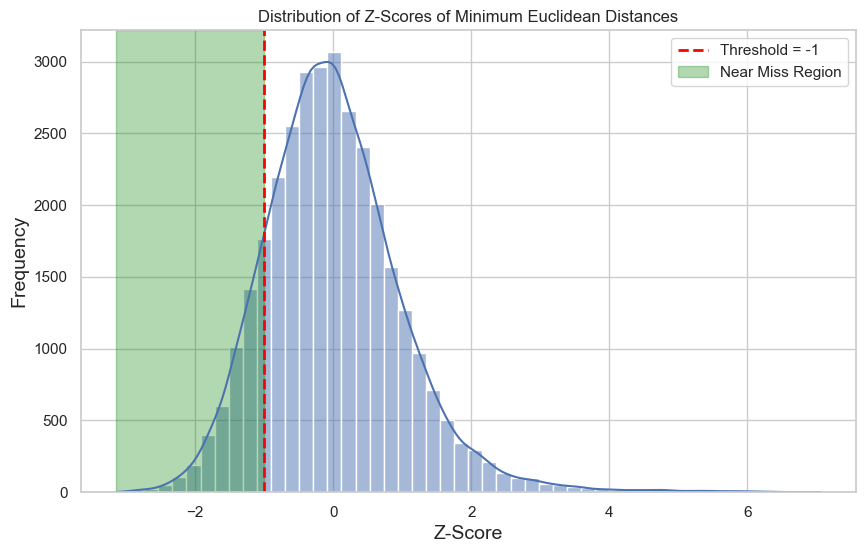

In [66]:
# Plot the distribution of z-scores
plt.figure(figsize=(10, 6))
sns.histplot(distances['z_score'], bins=50, kde=True)
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')

# Highlight the near miss region
plt.axvspan(distances['z_score'].min(), threshold, color='green', alpha=0.3, label='Near Miss Region')

plt.title('Distribution of Z-Scores of Minimum Euclidean Distances')
plt.xlabel('Z-Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Percentage of Near Miss Comparisons: 14.24%


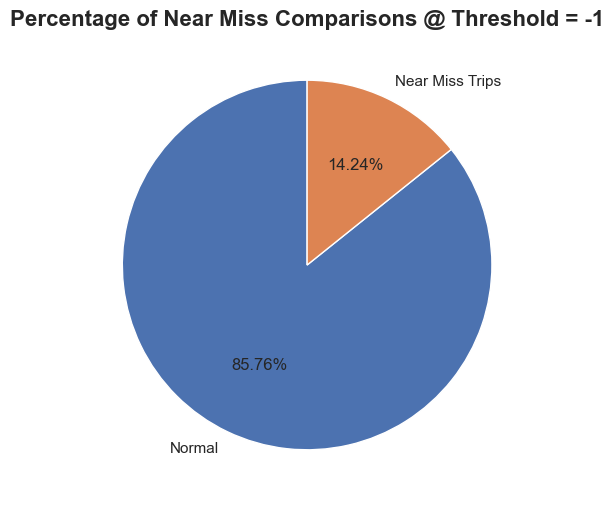

In [67]:
# Count how many z-scores are below a certain threshold as a percentage of the total

anomalies = distances[distances['z_score'] < threshold]

# Compute the percentage of anomalies
anomaly_percentage = len(anomalies) / len(distances) * 100

print(f'Percentage of Near Miss Comparisons: {anomaly_percentage:.2f}%')

# Plot the anomalies
plt.figure(figsize=(10, 6))
# plot a pie chart
plt.pie([len(distances) - len(anomalies), len(anomalies)], labels=['Normal', 'Near Miss Trips'], autopct='%1.2f%%', startangle=90)
plt.title(f'Percentage of Near Miss Comparisons @ Threshold = {threshold}', fontsize=16, fontweight='bold')
plt.show()

### Interpretation
- Since different queries had different means and standard deviations during comparisons, we z-normalized each distance based on the queries mean and std deviation
- In the Figure above, we can see that the distribution is centered at 0, and the x-axis represents the number of standard deviations away from the mean
- To the left of the mean represents closer matches between the query and trip subsequence, while to the right represents further matches

### Central Limit Theorem
- If we look at 2 (or 1.96) standard deviations away from the mean, the probability that a distance measurement lies within that it 95%. Therefor if we look to the left tail, there is a 2.5% chance that the data falls in this region. We can state that given that it is so unlikely (abnormal) that this happens, this could be defined as a near miss.
- Based on further studies, we can adjust this threshold to encompass a larger percentile. i.e. 5% (or 10% or 15%...) of trips have near misses

# Set the Near-Miss Threshold:

In [69]:
# Set the threshold (std deviations from the mean)
threshold = -1

In [70]:
# Function to get near-miss indices based on a threshold
def get_near_miss_indices(distance_profiles, threshold):
    new_near_miss_data = []

    for profile in distance_profiles:
        distance_profile = profile['distance_profile']
        
        # Find the indices where the distance profile values are less than the threshold
        near_miss_indices = np.where(distance_profile <= threshold)[0]
        
        # Append to the new list of dictionaries with the updated near_miss_indices
        new_near_miss_data.append({
            'trip_num': profile['trip_num'],
            'query_num': profile['query_num'],
            'near_miss_indicies': near_miss_indices,
            'near_miss_count': len(near_miss_indices)
        })
    
    # Create a DataFrame from the new near miss data
    return new_near_miss_data

In [71]:
# Get the new near miss indices based on the threshold
near_miss_threshold = get_near_miss_indices(distance_profiles, threshold)

In [72]:
# Extract trip num, query num, and near miss count to create a DataFrame
near_miss_data = [{'trip_num': profile['trip_num'], 'query_num': profile['query_num'], 'near_miss_count': profile['near_miss_count']} for profile in near_miss_threshold]

# Create the DataFrame
near_miss_seperated_df = pd.DataFrame(near_miss_data)

In [73]:
def near_miss_count_dataframe(distance_profiles):
    # Initialize a dictionary to store the total near miss count for each trip number
    trip_near_miss_counts = {}

    # Loop through each entry in the distance profiles dictionary
    for profile in distance_profiles:
        trip_num = profile['trip_num']
        near_miss_count = profile['near_miss_count']

        # Accumulate the near miss counts for each trip number
        if trip_num in trip_near_miss_counts:
            trip_near_miss_counts[trip_num] += near_miss_count
        else:
            trip_near_miss_counts[trip_num] = near_miss_count

    # Convert the dictionary to a DataFrame
    near_miss_df = pd.DataFrame(list(trip_near_miss_counts.items()), columns=['trip_num', 'total_near_miss_count'])
    
    return near_miss_df

In [74]:
near_miss_total_df = near_miss_count_dataframe(near_miss_threshold)

# Sort the near miss DataFrame by the total near miss count
near_miss_total_df = near_miss_total_df.sort_values(by='total_near_miss_count', ascending=False)

In [76]:
# Combine the trip info dataframe with the near miss dataframe on the trip number
near_miss_combined_df = near_miss_total_df.merge(trip_info, on='trip_num')

# Combine the distance traveled dataframe with the near miss datafrane on trip number
near_miss_combined_df = near_miss_combined_df.merge(distance_traveled_df, on='trip_num')

# Trips with the most near misses (Based on set threshold)

In [77]:
near_miss_combined_df.head(10)

,trip_num,total_near_miss_count,start_time,end_time,duration,distance_traveled_miles
0,5774,23,2023-06-28 08:29:11.227000+00:00,2023-06-28 09:18:56.240000+00:00,0 days 00:49:45.013000,41.955793
1,5109,23,2023-05-31 15:18:41.884000+00:00,2023-05-31 17:33:30.421000+00:00,0 days 02:14:48.537000,74.401593
2,6181,22,2023-07-13 12:42:50.423000+00:00,2023-07-13 14:21:13.639000+00:00,0 days 01:38:23.216000,118.257904
3,3431,21,2023-04-04 15:37:00.276000+00:00,2023-04-04 17:32:34.662000+00:00,0 days 01:55:34.386000,55.473750
4,2718,20,2023-03-12 16:16:59.374000+00:00,2023-03-12 20:49:26.032000+00:00,0 days 04:32:26.658000,338.867529
5,5797,18,2023-06-28 16:14:46.501000+00:00,2023-06-28 17:50:25.511000+00:00,0 days 01:35:39.010000,75.994247
6,556,17,2023-01-18 16:14:47.747000+00:00,2023-01-18 17:23:35.558000+00:00,0 days 01:08:47.811000,31.363381
7,1886,16,2023-02-17 10:54:25.948000+00:00,2023-02-17 13:13:14.524000+00:00,0 days 02:18:48.576000,174.130730
8,2712,15,2023-03-12 13:03:49.976000+00:00,2023-03-12 15:16:59.621000+00:00,0 days 02:13:09.645000,110.925946
9,3255,14,2023-03-28 10:28:08.056000+00:00,2023-03-28 12:08:51.326000+00:00,0 days 01:40:43.270000,121.003013


# Set the Trip to investigate here:

In [97]:
# Potential Impact Trips on Highway: 2672, 2791, 3612, 3638, 5039, 5159

trip_num = 3638

## Just run code blocks below to see where near misses occur in trips

In [98]:
# Set the trip we want to analyze
trip1_df = df_bc[df_bc['trip_num'] == trip_num]

In [99]:
# Find the overall trip details for the given trip number
trip_details = near_miss_combined_df[near_miss_combined_df['trip_num'] == trip_num]

trip_details.head()

,trip_num,total_near_miss_count,start_time,end_time,duration,distance_traveled_miles
2509,3638,1,2023-04-11 13:51:13.656000+00:00,2023-04-11 13:59:14.654000+00:00,0 days 00:08:00.998000,9.850797


In [100]:
# Get the specific near miss count for the trip
trip_near_miss_df = near_miss_seperated_df[near_miss_seperated_df['trip_num'] == trip_num]

trip_near_miss_df.head()

,trip_num,query_num,near_miss_count
3576,3638,7,0
10154,3638,13,0
16732,3638,21,0
29889,3638,34,1


In [101]:
# Add calculated fields for plotting
trip1_df['veh_long_vel_mph'] = trip1_df['veh_long_vel_mps'] * 2.237
trip1_df['veh_accel_mps2_analytical'] = trip1_df['veh_long_vel_mps'].diff()
trip1_df['veh_jerk_mps3_analytical'] = trip1_df['veh_accel_mps2_analytical'].diff()
trip1_df['lateral_velocity_analytical'] = trip1_df['veh_long_vel_mps'] * trip1_df['veh_yaw_rate_radps']

C:\Users\donav\AppData\Local\Temp\ipykernel_11756\1426235325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip1_df['veh_long_vel_mph'] = trip1_df['veh_long_vel_mps'] * 2.237
C:\Users\donav\AppData\Local\Temp\ipykernel_11756\1426235325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip1_df['veh_accel_mps2_analytical'] = trip1_df['veh_long_vel_mps'].diff()
C:\Users\donav\AppData\Local\Temp\ipykernel_11756\1426235325.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [102]:
# Set features to plot
features_to_plot = ['veh_long_vel_mps', 'veh_accel_mps2_analytical', 'veh_jerk_mps3_analytical', 'veh_ltrl_vel_mps', 'lateral_velocity_analytical', 'veh_yaw_rate_radps']

In [103]:
# Extract near miss time segments before plotting
near_miss_segments = []

# Loop through the distance_profiles to extract near miss segments
for profile in near_miss_threshold:
    if profile['trip_num'] == trip_num:
        query_num = profile['query_num']
        near_miss_indices = profile['near_miss_indicies']
        for index in near_miss_indices:
            # Get the timestamp for the start of the near miss and the 10-second interval
            start_time = trip1_df.iloc[index]['date_time']
            end_time = start_time + pd.Timedelta(seconds=10)
            near_miss_segments.append((start_time, end_time, query_num))

In [104]:
# Define a mapping of colors directly assigned to specific query numbers
query_colors = {
    7: '#1f77b4',    # Blue
    13: '#ff7f0e',   # Orange
    21: '#2ca02c',   # Green
    22: '#d62728',   # Red
    34: '#9467bd'    # Purple
}

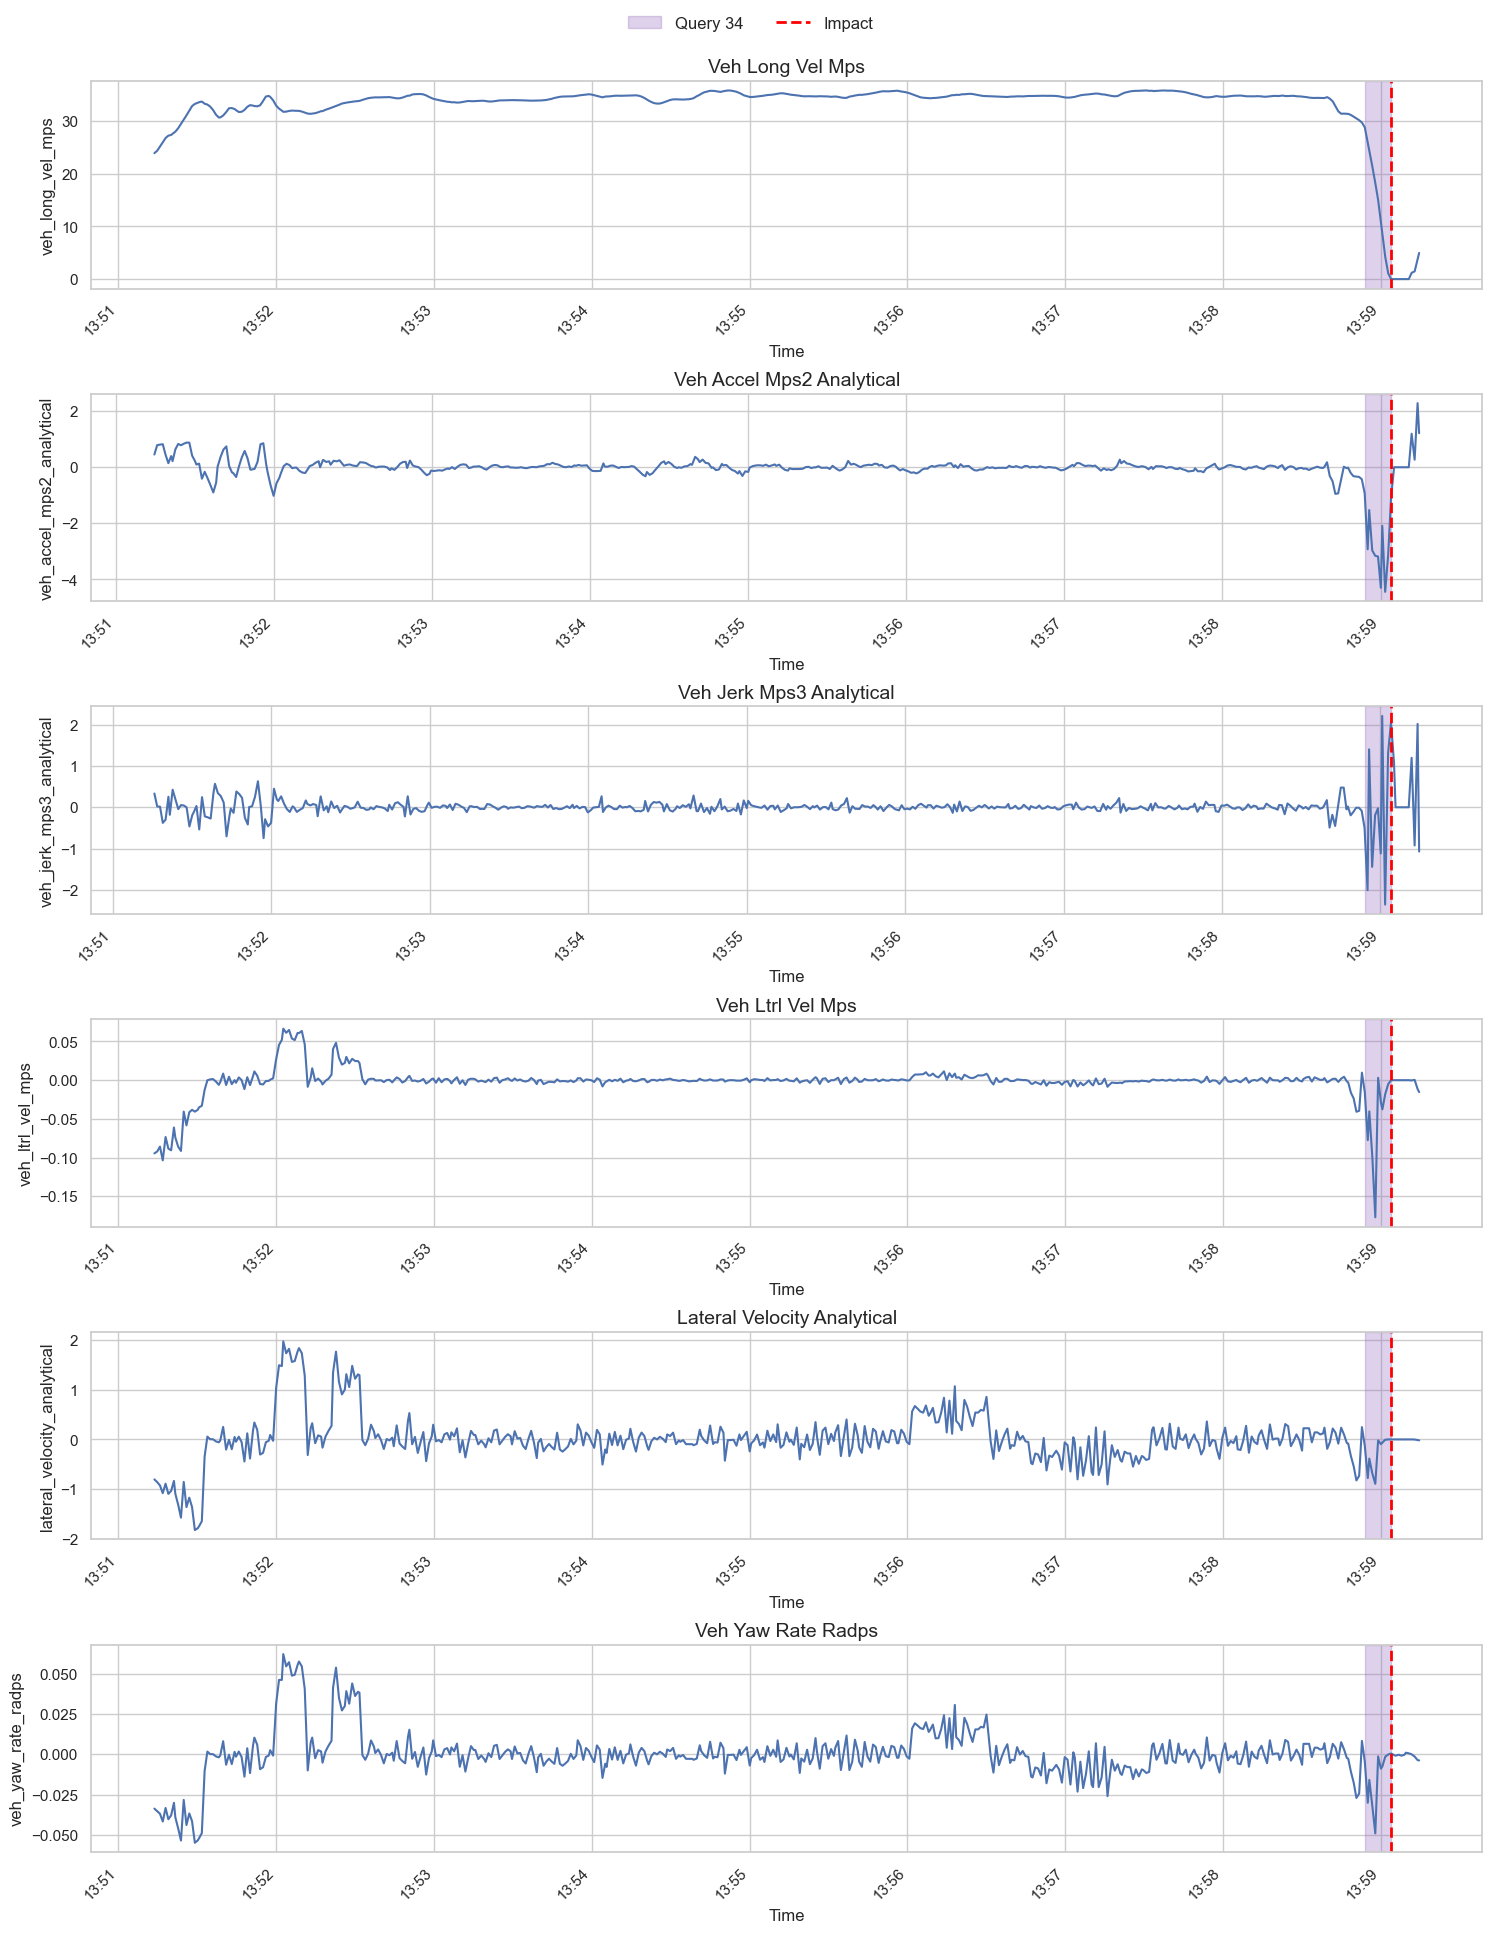

In [105]:

# Set the style of the plot
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(len(features_to_plot), 1, figsize=(15, 2 + (3 * len(features_to_plot))))

# Track which queries have been added to the legend
added_queries = set()

# Plot each feature against time
for i, feature in enumerate(features_to_plot):
    sns.lineplot(data=trip1_df, x='date_time', y=feature, ax=ax[i], linewidth=1.5, alpha=1)
    ax[i].set_title(feature.replace('_', ' ').title(), fontsize=14)
    ax[i].set_ylabel('mph' if 'mph' in feature else feature, fontsize=12)
    ax[i].set_xlabel('Time', fontsize=12)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')

    # Highlight near miss regions using the pre-extracted segments
    for start_time, end_time, query_num in near_miss_segments:
        # Add label to the legend only if this query_num has not been added yet
        label = f'Query {query_num}' if query_num not in added_queries else ""
        color = query_colors.get(query_num, '#000000')  # Use a default color if the query number is not in the mapping
        ax[i].axvspan(start_time, end_time, color=color, alpha=0.3, label=label)
        
        # Mark this query_num as added
        if label:
            added_queries.add(query_num)

# Loop over each subplot and add a red vertical line at the impact point
for i, feature in enumerate(features_to_plot):
    impact_points = trip1_df[trip1_df['impact_indicator'] == 1]['date_time']
    for impact_time in impact_points:
        ax[i].axvline(x=impact_time, color='red', linestyle='--', lw=2, label='Impact' if i == 0 else "")

# Add a single legend for the entire figure at the top center
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=len(added_queries) + 1, fontsize=12, frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Adjust the top to make space for the legend
plt.show()